# Descarga, lectura y escritura de archivos grb2 provenientes de los trabajos del centro de modelamiento ambiental del NOAA.

En este punto se usará el paquete wget, el cual es un paquete desarrollado en la función wget usada linux. Para esto se necesita:
1. Importar funcion descargasarchivos_multi1, conversiongrib2toCSVNOAA y EscrituraSwanFile.
2. Ejecutar los codigos para el rango temporal de 2009 a 2018, rango usado en la tesis.
3. Obtener archivos de batimetria para modelación.

In [1]:
# Descarga de archivo provenientes del NOAA
import sys
sys.path.insert(0, 'Script')

import numpy as np
from S001_preprocessingNOAA import descargasarchivos_multi1, conversiongrib2toCSVNOAA
from S002_writting import EscrituraSwanFile

# Descargar archivos provenientes del NOAA
min_year         = 2009
max_year         = 2018
path_folder_swn  = "Output/swn_NOAA"
path_folder_csv  = "Output/csv_NOAA"
path_folder_NOAA = "Data/grib_NOAA"
for var in ['dp','hs','tp']:
    descargasarchivos_multi1(path_folder_NOAA, var, min_year, max_year)

termino iteración de variable: dp
termino iteración de variable: hs
termino iteración de variable: tp


In [2]:
#Extracción de información de cada nodo y escritura en archivo CSV.
df_NOAA = conversiongrib2toCSVNOAA(path_folder_NOAA, path_folder_csv, [-32.50, -72.50, -33.50, -71.40], min_year, max_year)

In [3]:
# Parámetros para Escritura de archivos .swn
nodos = {
    "nodo1": [-71.50, -32.50, -72.00, -32.50],
    "nodo2": [-72.00, -32.50, -72.50, -32.50],
    "nodo3": [-72.50, -32.50, -72.50, -33.00],
    "nodo4": [-72.50, -33.00, -72.50, -33.50],
    "nodo5": [-72.50, -33.50, -72.00, -33.50],
    "nodo6": [-72.00, -33.50, -71.40, -33.50]
    }

parameters='XP YP DEPTH DIR HSIGN TPS &\nTM02 TMM10 HSWELL WLEN STEEPNESS BFI QP TRANSP FORCE TDIR'

In [4]:
# Escritura de archivos .swn, primero propagación (primer día)
sub_df_NOAA = df_NOAA.loc[df_NOAA.time<"2009-02-01"]
nombre_variables_NOAA = ["swh","perpw","dirpw"]

EscrituraSwanFile(
    sub_df_NOAA,  path_folder_swn, "P1-NOAA", nodos, parameters, nombre_variables_NOAA,
    area                = [-32.50, -72.50, -33.50, -71.40],                     # [N, W, S, E]
    sub_area            = [[-33.25, -72.00, -32.75, -71.40]],                   # [N, W, S, E]
    frequency           = [0.02, 1],                                            # flow, fhigh
    resolution_grid     = 60, 
    alpc                = 0.00, 
    mdc                 = 180, 
    bathymetry          = [-72.50625, -33.50625, 0.0, 291, 241, 15],            # xpinp, ypinp, alpinp, mxinp, myinp, dxyinp
    names_bath          = [-1, "bat_final3.bot", 3, 0],                         # fac, name, idla, nhedf
    numeric             = [0.005, 0.01, 0.005, 99.00, 100, 0.01],               # dabs, drel, curvat, npnts, mxitst, alfa
    resolution_subgrid  = 30,
    alpn                = 0.00,
    )

In [5]:
# Escritura de archivos .swn, segunda propagación (primer día)
EscrituraSwanFile(
    sub_df_NOAA,  path_folder_swn, "P2-1-NOAA", nodos, parameters, nombre_variables_NOAA,
    area                = [-33.25, -72.00, -32.75, -71.40],                     # [N, W, S, E]
    sub_area            = [],                                                   # [N, W, S, E]
    frequency           = [0.02, 1],                                            # flow, fhigh
    resolution_grid     = 30, 
    alpc                = 0.00, 
    mdc                 = 180, 
    bathymetry          = [-72.00625, -33.25625, 0.0, 145, 121, 15],            # xpinp, ypinp, alpinp, mxinp, myinp, dxyinp
    names_bath          = [-1, "bat_final4.bot", 3, 0],                         # fac, name, idla, nhedf
    numeric             = [0.005, 0.01, 0.005, 99.50, 50, 0.01],                # dabs, drel, curvat, npnts, mxitst, alfa
    resolution_subgrid  = 15,
    alpn                = 0.00,
    )

In [6]:
# Lectura de archivo de batimetria proveniente de GEBCO
import xarray as xr
from astropy.io import ascii

ds = xr.open_dataset("Data/Batimetria_GEBCO/gebco_2019_n-31.9937_s-35.00625_w-73.00625_e-71.2937.nc")

In [7]:
# "bat_final3.bot"
xpinp, ypinp, alpinp, mxinp, myinp, dxyinp = [-72.50625, -33.50625, 0.0, 291, 241, 15]

bat_final3 = ds.where(ds.lon >= xpinp, drop=True)\
    .where(ds.lat >= ypinp, drop=True)\
        .where(ds.lon <= xpinp + (mxinp+0.5)*(dxyinp/3600), drop=True)\
            .where(ds.lat <= ypinp + (myinp-0.5)*(dxyinp/3600), drop=True)
ascii.write(bat_final3.elevation.values, "Output/batimetria/bat_final3.bot",format='no_header',overwrite=True)

In [8]:
# "bat_final4.bot"
xpinp, ypinp, alpinp, mxinp, myinp, dxyinp = [-72.00625, -33.25625, 0.0, 145, 121, 15]

bat_final4 = ds.where(ds.lon >= xpinp, drop=True)\
    .where(ds.lat >= ypinp, drop=True)\
        .where(ds.lon <= xpinp + (mxinp+0.5)*(dxyinp/3600), drop=True)\
            .where(ds.lat <= ypinp + (myinp-0.5)*(dxyinp/3600), drop=True)
ascii.write(bat_final4.elevation.values, "Output/batimetria/bat_final4.bot",format='no_header',overwrite=True)

# [Opcion2] Usar datos del proyecto Copernicus.

En este punto se usará el paquete wget, el cual es un paquete desarrollado en la función wget usada linux. Para esto se necesita:
1.   Importar funcion descargas_era5copernicus

In [9]:
# Descargar archivos provenientes de Copernicus
import sys
sys.path.insert(0, 'Script')

import numpy as np
from S001_preprocessingCopernicus import descargas_era5copernicus, conversiongrib2toCSVCopernicus

min_year                = 2009
max_year                = 2018
path_folder_swn         = "Output/swn_Copernicus"
path_folder_csv         = "Output/csv_Copernicus"
path_folder_copernicus  = "Data/grib_Copernicus"
years                   = np.arange(min_year, max_year + 1, 1, dtype=int)
variables               = ['mean_wave_direction', 'model_bathymetry', 'peak_wave_period', 'significant_height_of_total_swell',]
area                    = [-32.50, -72.50, -33.50, -71.40]

for year in years:
    descargas_era5copernicus(path_folder_copernicus, year, variables, area)

In [10]:
# conversion a csv
df_Copernicus = conversiongrib2toCSVCopernicus(path_folder_copernicus, path_folder_csv, min_year, max_year)

In [11]:
# Parámetros para Escritura de archivos .swn
nodos = {
    "nodo1": [-71.50, -32.50, -72.00, -32.50],
    "nodo2": [-72.00, -32.50, -72.50, -32.50],
    "nodo3": [-72.50, -32.50, -72.50, -33.00],
    "nodo4": [-72.50, -33.00, -72.50, -33.50],
    "nodo5": [-72.50, -33.50, -72.00, -33.50],
    "nodo6": [-72.00, -33.50, -71.40, -33.50]
    }

parameters='XP YP DEPTH DIR HSIGN TPS &\nTM02 TMM10 HSWELL WLEN STEEPNESS BFI QP TRANSP FORCE TDIR'

In [12]:
# Escritura de archivos .swn, primero propagación (primer día)
sub_df_Copernicus = df_Copernicus.loc[df_Copernicus.time<"2009-02-01"]
nombre_variables_Copernicus = ["shts","pp1d","mwd"]

EscrituraSwanFile(
    sub_df_Copernicus,  path_folder_swn, "P1-ERA5", nodos, parameters, nombre_variables_Copernicus,
    area                = [-32.50, -72.50, -33.50, -71.40],                     # [N, W, S, E]
    sub_area            = [[-33.25, -72.00, -32.75, -71.40]],                   # [N, W, S, E]
    frequency           = [0.02, 1],                                            # flow, fhigh
    resolution_grid     = 60, 
    alpc                = 0.00, 
    mdc                 = 180, 
    bathymetry          = [-72.50625, -33.50625, 0.0, 291, 241, 15],            # xpinp, ypinp, alpinp, mxinp, myinp, dxyinp
    names_bath          = [-1, "bat_final3.bot", 3, 0],                         # fac, name, idla, nhedf
    numeric             = [0.005, 0.01, 0.005, 99.00, 100, 0.01],               # dabs, drel, curvat, npnts, mxitst, alfa
    resolution_subgrid  = 30,
    alpn                = 0.00,
    )

In [13]:
# Escritura de archivos .swn, segunda propagación (primer día)
EscrituraSwanFile(
    sub_df_Copernicus,  path_folder_swn, "P2-1-ERA5", nodos, parameters, nombre_variables_Copernicus,
    area                = [-33.25, -72.00, -32.75, -71.40],                     # [N, W, S, E]
    sub_area            = [],                                                   # [N, W, S, E]
    frequency           = [0.02, 1],                                            # flow, fhigh
    resolution_grid     = 30, 
    alpc                = 0.00, 
    mdc                 = 180, 
    bathymetry          = [-72.00625, -33.25625, 0.0, 145, 121, 15],            # xpinp, ypinp, alpinp, mxinp, myinp, dxyinp
    names_bath          = [-1, "bat_final4.bot", 3, 0],                         # fac, name, idla, nhedf
    numeric             = [0.005, 0.01, 0.005, 99.50, 50, 0.01],                # dabs, drel, curvat, npnts, mxitst, alfa
    resolution_subgrid  = 15,
    alpn                = 0.00,
    )

# Comparación datos

In [21]:
df_merge = df_NOAA.merge(df_Copernicus, on=["latitude", "longitude","time"], suffixes=("_NOAA","_Copernicus")).dropna()
df_merge.head()

,latitude,longitude,time,dirpw,perpw,swh,mwd,wmb,pp1d,shts
0,-32.5,-72.5,2009-01-01 00:00:00,215.02,10.08,2.78,214.70332,999.0,10.376808,2.455078
1,-32.5,-72.5,2009-01-01 03:00:00,214.50,10.20,2.89,215.05634,999.0,10.425636,2.526733
2,-32.5,-72.5,2009-01-01 06:00:00,214.10,10.30,3.02,215.75185,999.0,11.006691,2.836426
3,-32.5,-72.5,2009-01-01 09:00:00,213.70,10.37,3.13,216.54155,999.0,10.909523,2.806152
4,-32.5,-72.5,2009-01-01 12:00:00,225.34,17.75,3.24,217.02150,999.0,10.841652,2.809395


In [22]:
print(df_merge.latitude.unique())
print(df_merge.longitude.unique())

import itertools
latlon = [[x, y] for x, y in itertools.product(df_merge.longitude.unique(), df_merge.latitude.unique())]

[-32.5 -33.  -33.5]
[-72.5 -72.  -71.5]


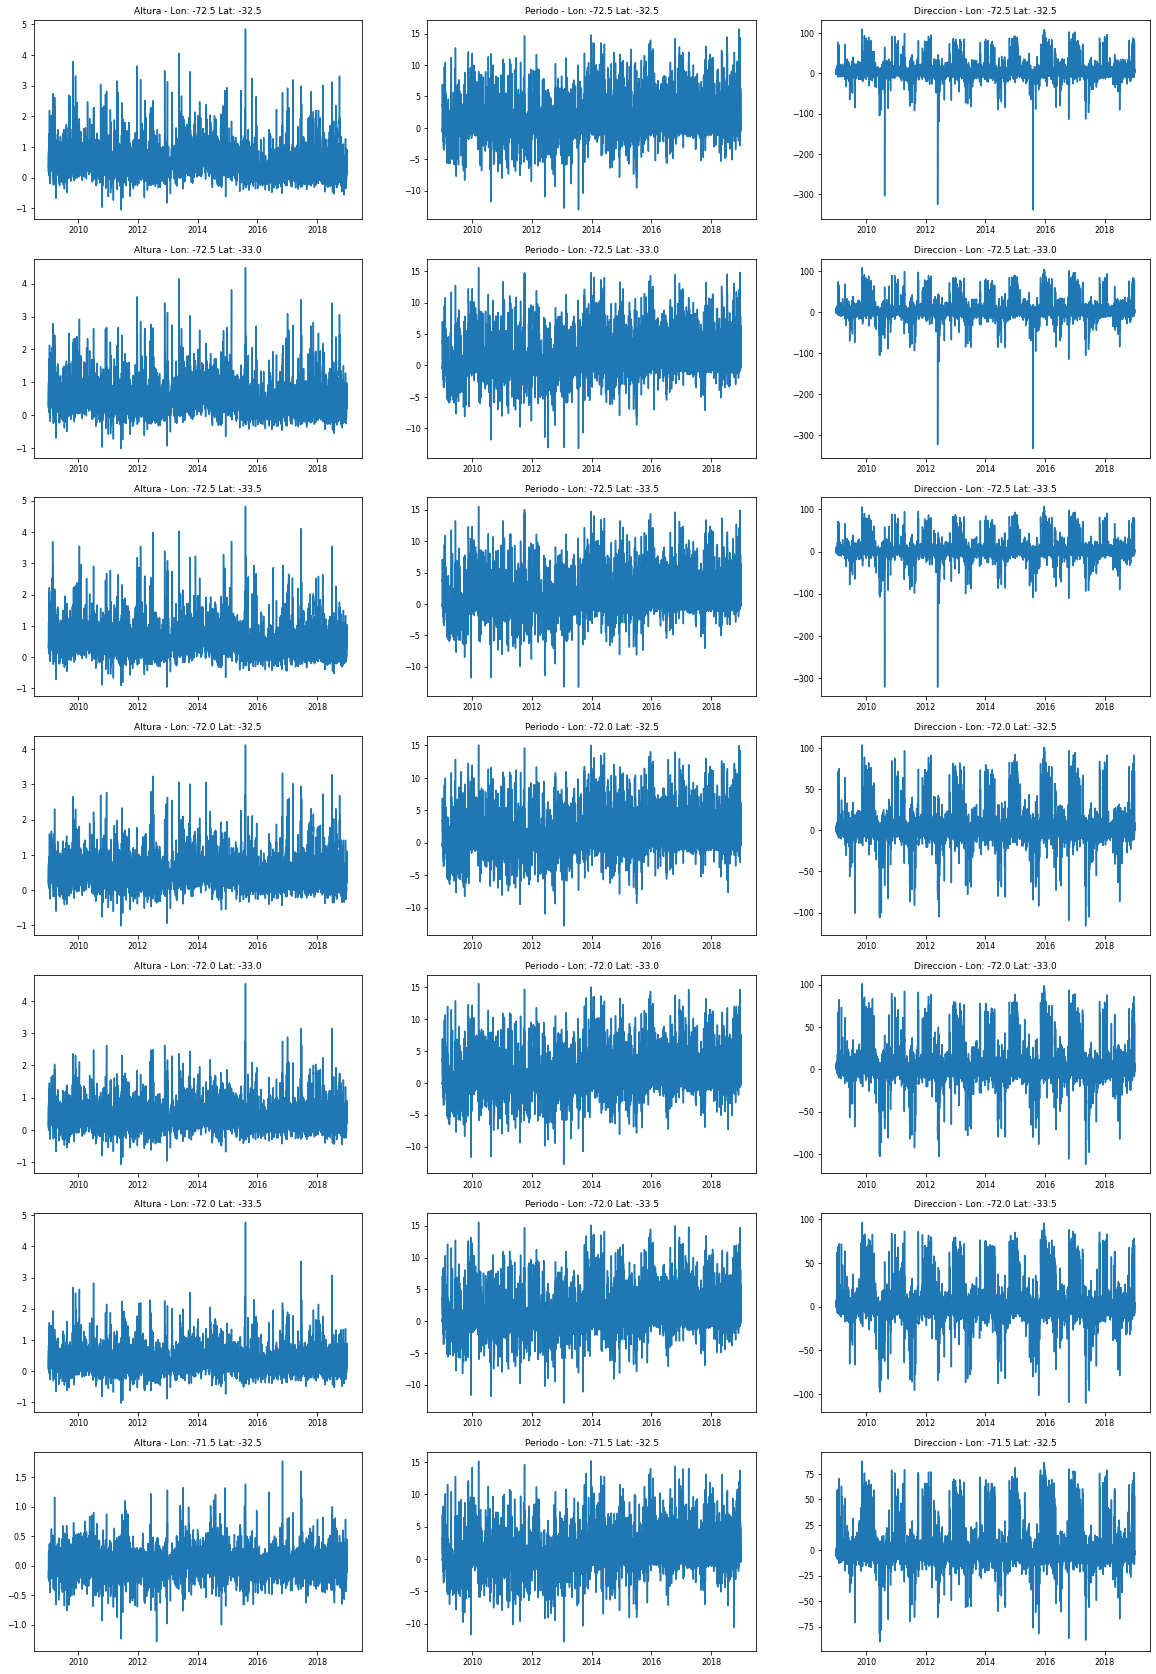

In [41]:
import matplotlib.pyplot as plt

_, axes = plt.subplots(ncols=3, nrows=7, figsize=(20,30))
n, n_latlon = 0, 0
for ax in axes.flatten():
    if n%3==2:
        diff_direccion = df_merge.loc[(df_merge.longitude==x)&(df_merge.latitude==y), nombre_variables_NOAA[-1]] \
            - df_merge.loc[(df_merge.longitude==x)&(df_merge.latitude==y), nombre_variables_Copernicus[-1]]
        ax.plot(df_merge.loc[(df_merge.longitude==x)&(df_merge.latitude==y), "time"], diff_direccion)
        ax.set_title("Direccion - Lon: {:.1f} Lat: {:.1f}".format(x, y), fontsize=9)
        n_latlon+=1
    elif n%3==1:
        diff_periodo = df_merge.loc[(df_merge.longitude==x)&(df_merge.latitude==y), nombre_variables_NOAA[1]] \
            - df_merge.loc[(df_merge.longitude==x)&(df_merge.latitude==y), nombre_variables_Copernicus[1]]
        ax.plot(df_merge.loc[(df_merge.longitude==x)&(df_merge.latitude==y), "time"], diff_periodo)
        ax.set_title("Periodo - Lon: {:.1f} Lat: {:.1f}".format(x, y), fontsize=9)
    else:
        (x, y) = latlon[n_latlon]
        diff_altura = df_merge.loc[(df_merge.longitude==x)&(df_merge.latitude==y), nombre_variables_NOAA[0]] \
            - df_merge.loc[(df_merge.longitude==x)&(df_merge.latitude==y), nombre_variables_Copernicus[0]]
        ax.plot(df_merge.loc[(df_merge.longitude==x)&(df_merge.latitude==y), "time"], diff_altura)
        ax.set_title("Altura - Lon: {:.1f} Lat: {:.1f}".format(x, y), fontsize=9)
    n+=1
    ax.tick_params("both", labelsize=8)